In [1]:
#import stuff, and set seaborn up
from scipy.stats import norm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import pandas as pd
import time
from scipy.optimize import minimize

# All the functions

In [200]:
#define functions

#create function that finds mean of a function
def mean_pop(a):
    mean = 0
    for i in range(len(a)):
        mean += a[i]*i

    mean = int(mean/sum(a))

    return mean

#create function that finds mean of a population
def weighted_total(a):
    weighted_total=0
    history_number=np.zeros((100,1)) #100 being the number of possible credit scores
    for i in range(100):
        number=sum(a==i) #number being the number of people having credit score i
        weighted_total+=number*i
        history_number[i]=number
    
    weighted_total/=sum(history_number)
    
    return weighted_total

#creates random distributions
def brownian_population(delta=2, dt=1, n=100, x=0):

    history=np.zeros(n)
    
    # Iterate to compute the steps of the Brownian motion.
    for i in range(n):
        x = x + norm.rvs(scale=delta**2*dt)
        history[i] = x
    
    history = history+np.abs(np.min(history))
    
    original_hist = np.copy(history)
    old_mean = mean_pop(original_hist)
    
    history = np.round(999*history/sum(history))
    
    mean = np.round(np.average(history))
    
    if sum(history) < 999:
        history[0] += 999-sum(history)
        
    elif sum(history) > 999:  
        history[np.argmax(history)] -= -999+sum(history)        
    

    return history, old_mean, original_hist

#create function that finds true positive rates as a function of the cutoff
def true_positive_rate(population, population_that_defaulted, cutoff):
    population_bank_thinks_defaulted = population < cutoff
    
    true_positives = np.logical_and(np.logical_not(population_that_defaulted), 
                                    np.logical_not(population_bank_thinks_defaulted))
    
    number_true_positives = sum(true_positives)
    
    false_negatives = np.logical_and(np.logical_not(population_that_defaulted), 
                                     population_bank_thinks_defaulted)
    
    number_false_negatives = sum(false_negatives) 
    
    true_positive_rate = number_true_positives/(number_true_positives+number_false_negatives)
    
    return true_positive_rate

def difference_bw_positive_rates(pop1, pop2, pop1_that_defaulted, 
                                 pop2_that_defaulted, cutoff1, cutoff2, strictness=0.01):
    true_positive_rate_group1 = true_positive_rate(pop1, pop1_that_defaulted, cutoff1)
    true_positive_rate_group2 = true_positive_rate(pop2, pop2_that_defaulted, cutoff2)
    # for the optimiser's constraints
    return strictness - np.abs(true_positive_rate_group1-true_positive_rate_group2)

def difference_bw_selection_rates(pop1, pop2, pop1_that_defaulted, 
                                  pop2_that_defaulted, cutoff1, cutoff2, strictness=0.01):
    
    _, selection_rate_group1, _ = bank_profit(pop1, pop1_that_defaulted, cutoff1)
    _, selection_rate_group2, _ = bank_profit(pop2, pop2_that_defaulted, cutoff2)
    
    return strictness - np.abs(selection_rate_group1-selection_rate_group2)

#create function that finds bank profit as a function of the cutoff
def bank_profit(population, population_that_defaulted, cutoff, 
                revenue_factor=1, cost_factor=3, credit_upside=1, credit_downside=2):
    population_bank_thinks_defaulted = population < cutoff
    
    true_positives = np.logical_and(np.logical_not(population_that_defaulted), 
                                    np.logical_not(population_bank_thinks_defaulted))
    
    paid_back = sum(true_positives)
    false_positives = np.logical_and(population_that_defaulted, 
                                     np.logical_not(population_bank_thinks_defaulted))
    defaulted = sum(false_positives)
    
    profit = paid_back*revenue_factor - defaulted*cost_factor
    selection_rate = sum(np.logical_not(population_bank_thinks_defaulted))/len(population)
    
    credit_change = (paid_back*credit_upside - defaulted*credit_downside)

    
    return profit, selection_rate, credit_change

def total_bank_profit(pop1, pop2, pop1_that_defaulted, pop2_that_defaulted, cutoff1, cutoff2, 
                      revenue_factor=1, cost_factor=2, credit_upside=1, credit_downside=2):
    
    profit_group1, _, _ = bank_profit(pop1, pop1_that_defaulted, cutoff1)
    profit_group2, _, _ = bank_profit(pop2, pop2_that_defaulted, cutoff2)
    
    return -(profit_group1 + profit_group2)

def create_blues_and_oranges():
    a, mean_a, _ = brownian_population()
    b, mean_b, _ = brownian_population()

    if mean_a >= mean_b:
        blues = np.copy(b)
        oranges = np.copy(a)
    elif mean_a < mean_b:
        blues = np.copy(a)
        oranges = np.copy(b)
    else:
        print("um")

    true_blues = np.zeros(1)
    true_oranges = np.zeros(1)
    
    for i in range(100):
        num_blues = int(blues[i])
        num_oranges = int(oranges[i])
        
        if num_blues >= 0 and num_oranges >= 0:

            elements_blues = np.multiply(np.ones(num_blues),i)
            elements_oranges = np.multiply(np.ones(num_oranges), i)

            true_blues = np.concatenate((true_blues, elements_blues), axis=0)
            true_oranges = np.concatenate((true_oranges, elements_oranges), axis=0)

    #determine who defaulted
    blues_who_defaulted = true_blues.T < np.random.uniform(0, 100, (1000,1)).ravel()
    oranges_who_defaulted = true_oranges.T < np.random.uniform(0, 100, (1000,1)).ravel()

    blues = true_blues.T
    oranges = true_oranges.T
    
    return blues, oranges, blues_who_defaulted, oranges_who_defaulted, mean_a, mean_b
    

In [197]:
b, o, bwd, owd, mb, mo = create_blues_and_oranges()

In [198]:
number_of_iterations = 20
history_blue = np.zeros((number_of_iterations+1, 1000))
history_orange = np.zeros((number_of_iterations+1, 1000))
cutoff_history=np.zeros((number_of_iterations,2))
b, o, bwd, owd, mb, mo = create_blues_and_oranges()
history_blue[0]=b
history_orange[0]=o


for i in range(number_of_iterations):
    
    
    #optimise cutoffs without fairness
    #what to optimise
    to_optimise = lambda x: total_bank_profit(b, o, bwd, 
                                              owd, x[0], x[1])

    to_constrain = lambda x: difference_bw_positive_rates(b, o, bwd, 
                                                          owd, x[0], x[1])

    #initial guess
    cutoffs = np.zeros(2)
    cutoffs[0] = 50
    cutoffs[1] = 50
    #show initial objective
    print("initial guess of", cutoffs, "got us a profit of ", -to_optimise(cutoffs), "$")
    
    #optimise without fairness
    a = (0, 100)
    bounds = (a, a)

    solution_unfair = minimize(to_optimise, cutoffs, 
                        bounds=bounds, options = {'eps': 3})

    x_unfair = solution_unfair.x
    
    
    loans_b = b < x_unfair[0]
    true_positives_b = np.logical_and(np.logical_not(bwd), np.logical_not(loans_b))
    false_positives_b = np.logical_and(np.logical_not(loans_b), bwd)
    
    true_positives_o = np.logical_and(np.logical_not(owd), np.logical_not(loans_o))
    false_positives_o = np.logical_and(np.logical_not(loans_o), owd)
    
    b[true_positives_b] +=1
    b[false_positives_b] -=2
    b[b<1] = 1
    b[b>99] = 99
    
    o[true_positives_o] +=1
    o[false_positives_o] -=2
    o[o<1] = 1
    o[o>99] = 99
    
    history_blue[i+1]=b
    history_orange[i+1]=o
    cutoff_history[i]=x_unfair
    
    b_defaults = np.random.randint(100, size=(1000,))
    o_defaults = np.random.randint(100, size=(1000,))
    
    bwd = b < b_defaults
    owd = o < o_defaults
    

initial guess of [50. 50.] got us a profit of  -76 $
initial guess of [50. 50.] got us a profit of  36 $
initial guess of [50. 50.] got us a profit of  -2 $
initial guess of [50. 50.] got us a profit of  -91 $
initial guess of [50. 50.] got us a profit of  23 $
initial guess of [50. 50.] got us a profit of  21 $
initial guess of [50. 50.] got us a profit of  96 $
initial guess of [50. 50.] got us a profit of  106 $
initial guess of [50. 50.] got us a profit of  24 $
initial guess of [50. 50.] got us a profit of  51 $
initial guess of [50. 50.] got us a profit of  79 $
initial guess of [50. 50.] got us a profit of  76 $
initial guess of [50. 50.] got us a profit of  8 $
initial guess of [50. 50.] got us a profit of  65 $
initial guess of [50. 50.] got us a profit of  31 $
initial guess of [50. 50.] got us a profit of  11 $
initial guess of [50. 50.] got us a profit of  40 $
initial guess of [50. 50.] got us a profit of  37 $
initial guess of [50. 50.] got us a profit of  93 $
initial gu

In [ ]:
for i in range(20):
    print(weighted_total(history_blue[i]))

[36.197]
[36.27]


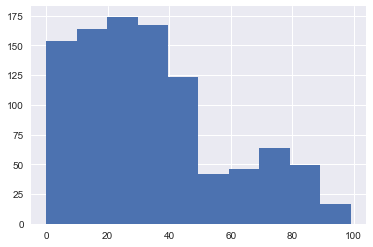

In [154]:
plt.hist(history_blue[0])
plt.show()

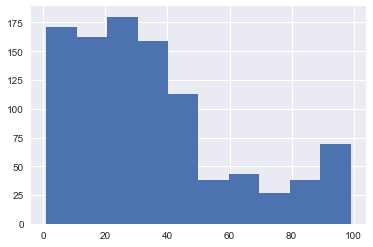

In [155]:
plt.hist(history_blue[19])
plt.show()

In [65]:
print(x_unfair[0], x_unfair[1], bwd.shape, b.shape)

49.21657424883481 63.940702946514705 (1000,) (1000,)


In [82]:
loans_b = b < x_unfair[0]

In [86]:
true_positives = np.logical_and(np.logical_not(bwd), np.logical_not(loans_b))
false_positives = np.logical_and(np.logical_not(loans_b), bwd)

## Find a way to create populations

In [5]:
a, mean_a, _ = brownian_population()
b, mean_b, _ = brownian_population()

if mean_a > mean_b:
    blues = np.copy(b)
    oranges = np.copy(a)
else:
    blues = np.copy(a)
    oranges = np.copy(b)
    
true_blues = np.zeros(1)
true_oranges = np.zeros(1)

for i in range(100):
    num_blues = int(blues[i])
    num_oranges = int(oranges[i])
    elements_blues = np.multiply(np.ones(num_blues),i)
    elements_oranges = np.multiply(np.ones(num_oranges), i)
    
    true_blues = np.concatenate((true_blues, elements_blues), axis=0)
    true_oranges = np.concatenate((true_oranges, elements_oranges), axis=0)
    
#determine who defaulted
blues_who_defaulted = true_blues.T < np.random.uniform(0, 100, (1000,1)).ravel()
oranges_who_defaulted = true_oranges.T < np.random.uniform(0, 100, (1000,1)).ravel()

blues = true_blues.T
oranges = true_oranges.T

## Plot populations

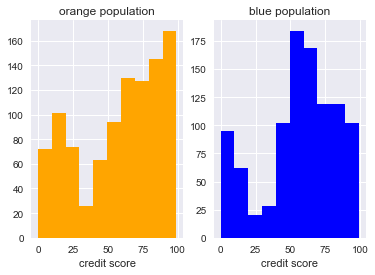

In [6]:
plt.subplot(121)
plt.hist(oranges, bins=10, color="orange")
plt.xlabel("credit score")
plt.title("orange population")
plt.subplot(122)
plt.hist(blues, bins=10, color="b")
plt.xlabel("credit score")
plt.title("blue population")
plt.show()


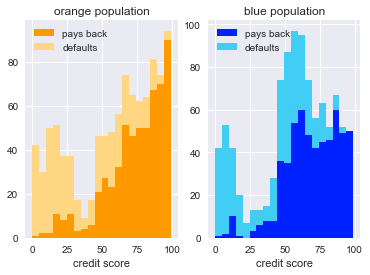

In [7]:
plt.subplot(121)
plt.hist([true_oranges[np.logical_not(oranges_who_defaulted)],true_oranges[oranges_who_defaulted]], 
         stacked=True, bins=20, color=("#ff9900", "#ffd782"))
plt.legend(("pays back", "defaults"))
plt.title("orange population")
plt.xlabel("credit score")
plt.subplot(122)
plt.hist([true_blues[np.logical_not(blues_who_defaulted)],true_blues[blues_who_defaulted]], 
         stacked=True, bins=20, color=("#0021ff", "#41cdf4"))
plt.legend(("pays back", "defaults"))
plt.title("blue population")
plt.xlabel("credit score")
plt.show()

## Optimise for the first time

In [8]:
#what to optimise
to_optimise = lambda x: total_bank_profit(blues, oranges, blues_who_defaulted, 
                                          oranges_who_defaulted, x[0], x[1])

to_constrain = lambda x: difference_bw_positive_rates(blues, oranges, blues_who_defaulted, 
                                                      oranges_who_defaulted, x[0], x[1])

#initial guess
cutoffs = np.zeros(2)
cutoffs[0] = 50
cutoffs[1] = 50
#show initial objective
print("initial guess of", cutoffs, "got us a profit of ", -to_optimise(cutoffs), "$")

initial guess of [50. 50.] got us a profit of  271 $


### With fairness

In [9]:
#optimise with fairness
a = (0, 100)
bounds = (a, a)
equal_true_positives = {'type': 'ineq', 'fun': to_constrain}
cons = ([equal_true_positives])

solution = minimize(to_optimise, cutoffs, method='SLSQP', constraints = cons,
                    bounds=bounds, options = {'eps': 3})

x_fair = solution.x

In [10]:
print(x_fair)

#final solution got us a profit of:
print("final guess of", x_fair, "got us a profit of ", -to_optimise(x_fair), "$")

_, _, blues_credit_change = bank_profit(blues, blues_who_defaulted, x_fair[0])
_, _, oranges_credit_change = bank_profit(oranges, oranges_who_defaulted, x_fair[1])
#final solution got us a change in credit score of:
print("total credit score change for blues:", blues_credit_change, 
      "|| total credit score change for oranges:", oranges_credit_change)

[50.21099974 51.72102009]
final guess of [50.21099974 51.72102009] got us a profit of  287 $
total credit score change for blues: 94 || total credit score change for oranges: 193


### Without fairness

In [11]:
#optimise without fairness
a = (0, 100)
bounds = (a, a)

solution_unfair = minimize(to_optimise, cutoffs, method='SLSQP',
                    bounds=bounds, options = {'eps': 3})

x_unfair = solution_unfair.x

In [12]:
#final solution got us a profit of:
print("final guess of", x_unfair, "got us a profit of ", -to_optimise(x_unfair), "$")

_, _, blues_credit_change = bank_profit(blues, blues_who_defaulted, x_unfair[0])
_, _, oranges_credit_change = bank_profit(oranges, oranges_who_defaulted, x_unfair[1])
#final solution got us a change in credit score of:
print("total credit score change for blues:", blues_credit_change, 
      "|| total credit score change for oranges:", oranges_credit_change)

final guess of [63.5508819  66.99433716] got us a profit of  437 $
total credit score change for blues: 196 || total credit score change for oranges: 241


# Do this all systematically

## 1. With fairness

In [13]:
num_its = 1000

profit_eq_opt = np.zeros(num_its)
credit_change_blues_eq_opt = np.zeros(num_its)
credit_change_oranges_eq_opt = np.zeros(num_its)

population_log_blues = np.zeros((num_its, 1000))
population_log_oranges = np.zeros((num_its, 1000))

profit_no_fairness = np.zeros(num_its)
credit_change_blues_no_fairness = np.zeros(num_its)
credit_change_oranges_no_fairness = np.zeros(num_its)

#initial guess
cutoffs = np.zeros(2)
cutoffs[0] = 50
cutoffs[1] = 50

#optimise bank profit
to_optimise = lambda x: total_bank_profit(blues, oranges, blues_who_defaulted, 
                                      oranges_who_defaulted, x[0], x[1])

#impose bounds
a = (0, 100)
bounds = (a, a)

how_long_did_it_take = time.time()

for i in range(num_its):
    t = time.time()
    
    
    blues, oranges, blues_who_defaulted, oranges_who_defaulted, _, _ = create_blues_and_oranges()
    
    population_log_blues[i] = blues
    population_log_oranges[i] = oranges
    
    to_constrain = lambda x: difference_bw_positive_rates(blues, oranges, blues_who_defaulted, 
                                                          oranges_who_defaulted, x[0], x[1])
    
    equal_true_positives = {'type': 'ineq', 'fun': to_constrain}
    cons = ([equal_true_positives])

    solution_unfair = minimize(to_optimise, cutoffs, method='SLSQP', 
                        constraints = cons, bounds=bounds, options = {'eps': 3, 'maxiter': 10})

    x_fair = solution_unfair.x
    

    profit_eq_opt[i] = -to_optimise(x_fair)
    _, _, credit_change_blues_eq_opt[i] = bank_profit(blues, blues_who_defaulted, x_fair[0])
    _, _, credit_change_oranges_eq_opt[i] = bank_profit(oranges, oranges_who_defaulted, x_fair[1])
    
    
    solution_fair = minimize(to_optimise, cutoffs, method='SLSQP', 
                        bounds=bounds, options = {'eps': 3})

    x_unfair = solution_fair.x
    
    profit_no_fairness[i] = -to_optimise(x_unfair)
    _, _, credit_change_blues_no_fairness[i] = bank_profit(blues, blues_who_defaulted, x_unfair[0])
    _, _, credit_change_oranges_no_fairness[i] = bank_profit(oranges, oranges_who_defaulted, x_unfair[1])
    
    
    
    if (i % 50 == 0):
        print("iteration", i, "(which took", time.time() - t, "seconds).")

print("This took very long to run", (time.time() - how_long_did_it_take)/60, "minutes to be exact.")

iteration 0 (which took 3.6158430576324463 seconds).
iteration 50 (which took 3.0580570697784424 seconds).
iteration 100 (which took 2.5138051509857178 seconds).
iteration 150 (which took 4.194777965545654 seconds).
iteration 200 (which took 1.0851049423217773 seconds).
iteration 250 (which took 1.2778050899505615 seconds).
iteration 300 (which took 2.3552629947662354 seconds).
iteration 350 (which took 3.276409149169922 seconds).
iteration 400 (which took 3.9111328125 seconds).
iteration 450 (which took 2.294743061065674 seconds).
iteration 500 (which took 0.8366189002990723 seconds).
iteration 550 (which took 0.93271803855896 seconds).
iteration 600 (which took 2.1500322818756104 seconds).
iteration 650 (which took 1.3770167827606201 seconds).
iteration 700 (which took 3.384246826171875 seconds).
iteration 750 (which took 3.6915969848632812 seconds).
iteration 800 (which took 3.4043211936950684 seconds).
iteration 850 (which took 0.9768369197845459 seconds).
iteration 900 (which took

## Plot distributions of populations under fairness and no fairness constraints

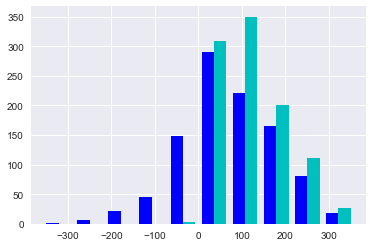

In [14]:
plt.hist((credit_change_blues_eq_opt, credit_change_blues_no_fairness), color=("b", "c"))
plt.show()

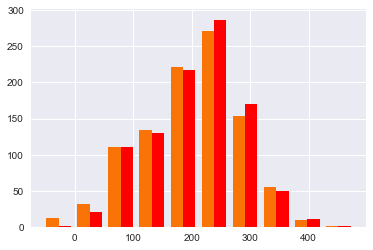

In [15]:
plt.hist((credit_change_oranges_eq_opt, credit_change_oranges_no_fairness), color=("xkcd:orange", "r"))
plt.show()

In [16]:
print("Fairness blues got", sum(credit_change_blues_eq_opt), 
      "whereas unfair blues got", sum(credit_change_blues_no_fairness))

print("Fairness oranges got", sum(credit_change_oranges_eq_opt), 
      "whereas unfair oranges got", sum(credit_change_oranges_no_fairness))

Fairness blues got 73856.0 whereas unfair blues got 120523.0
Fairness oranges got 200159.0 whereas unfair oranges got 207030.0


In [17]:
comparisons_smaller = credit_change_blues_eq_opt < credit_change_blues_no_fairness
comparisons_bigger = credit_change_blues_eq_opt > credit_change_blues_no_fairness
comparisons_equal = np.abs(credit_change_blues_eq_opt - credit_change_blues_no_fairness) < 3

# Generate pretty plots

1. What's the gap between unfair and fair classification
2. What do the distributions look like?
3. How many people default?


### 1. What's the gap between unfair and fair classification

In [18]:
average_blue = np.average(population_log_blues, axis=0)
average_orange = np.average(population_log_oranges, axis=0)
average_distance = average_orange-average_blue
average_distance.shape

(1000,)

In [19]:
frame = np.concatenate((credit_change_blues_eq_opt.reshape(1000,1), 
                        credit_change_oranges_eq_opt.reshape(1000,1), 
                        credit_change_blues_no_fairness.reshape(1000,1), 
                        credit_change_oranges_no_fairness.reshape(1000,1)), axis=1)



change_for_blues = np.concatenate((credit_change_blues_eq_opt.reshape(1000,1), 
                                   credit_change_blues_no_fairness.reshape(1000,1),
                                   average_distance.reshape(1000,1)), axis=1)

credit_changes_blue = pd.DataFrame(change_for_blues)
credit_changes_blue.columns = ["blue with equal opportunity",
                               "blue with no constraints",
                               "average distance"]


credit_changes = pd.DataFrame(frame)
credit_changes.columns = ["blue with equal opportunity", 
                          "orange with equal opportunity", 
                          "blue with no constraint", 
                          "oranges with no constraint"]

In [20]:
credit_changes_blue["distance"] = credit_changes_blue["blue with no constraints"] - credit_changes_blue["blue with equal opportunity"]

credit_changes_blue = credit_changes_blue.sort_values("distance", ascending=False)

credit_changes_blue["sorted index"] = np.arange(1000)
credit_changes_blue.head()

,blue with equal opportunity,blue with no constraints,average distance,distance,sorted index
881,-357.0,32.0,8.845,389.0,0
972,-233.0,99.0,3.460,332.0,1
608,-261.0,70.0,15.551,331.0,2
100,-210.0,89.0,7.482,299.0,3
793,-153.0,138.0,12.285,291.0,4


In [21]:
sum(credit_changes_blue["average distance"] < 0)

0

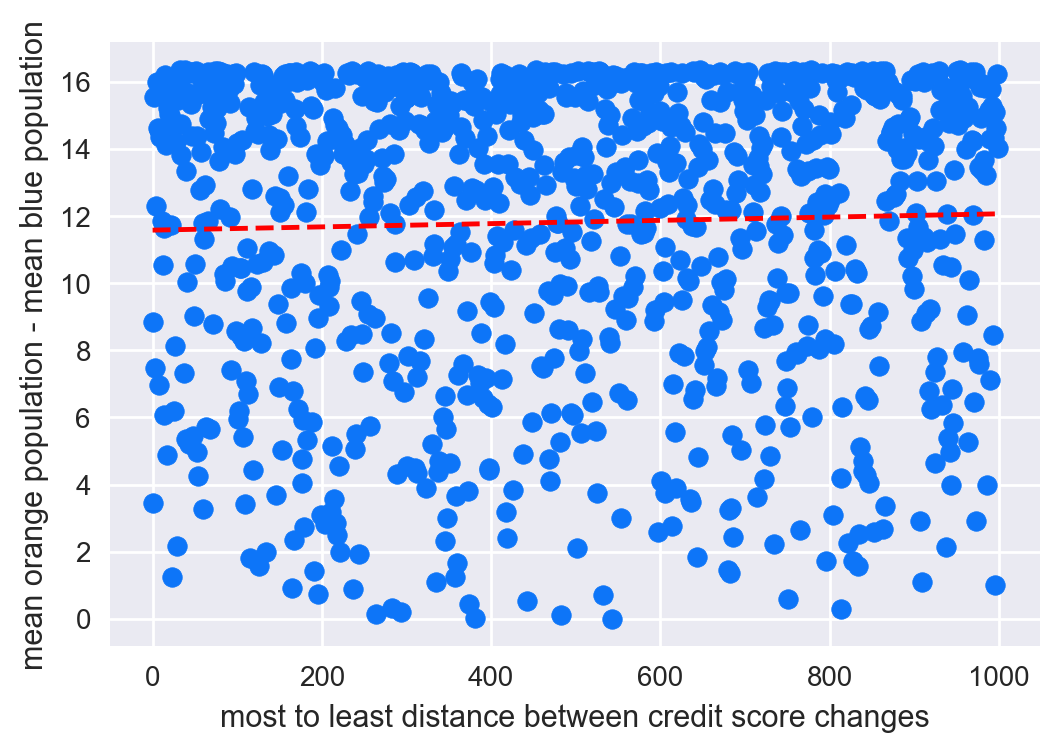

In [81]:
plt.figure(dpi=200)

credit_changes_blue_sub = credit_changes_blue.sample(1000)

trendline = np.polyfit(credit_changes_blue_sub["sorted index"], credit_changes_blue_sub["average distance"], 1)
p = np.poly1d(trendline)
plt.scatter(credit_changes_blue_sub["sorted index"],credit_changes_blue_sub["average distance"], c='xkcd:deep sky blue')
plt.plot(credit_changes_blue["sorted index"], p(credit_changes_blue["sorted index"]), "r--")
plt.ylabel("mean orange population - mean blue population")
plt.xlabel("most to least distance between credit score changes")
plt.savefig("plots/big_sim/GOOD_worse_doesnt_help.png")
plt.show()

In [23]:
credit_changes_blue.tail()

,blue with equal opportunity,blue with no constraints,average distance,distance,sorted index
9,153.0,129.0,1.001,-24.0,995
651,84.0,52.0,15.087,-32.0,996
681,140.0,105.0,14.632,-35.0,997
451,225.0,187.0,16.242,-38.0,998
717,157.0,106.0,14.035,-51.0,999


In [24]:
print(credit_changes_blue.index[-2])
distance_far = 0
distance_close = 0
distance_medium = 0
for i in range(20):
    index = credit_changes_blue.index[i]
    distance_far += np.average(population_log_oranges[index]) - np.average(population_log_blues[index])

for i in range(20):
    index = credit_changes_blue.index[-i]
    distance_close += np.average(population_log_oranges[index]) - np.average(population_log_blues[index])
    
    
for i in range(20):
    index = credit_changes_blue.index[i+490]
    distance_medium +=np.average(population_log_oranges[index]) - np.average(population_log_blues[index])
print("far=",distance_far/20, "|| close=",distance_close/20, "|| medium=", distance_medium/20)

451
far= 24.36715 || close= 9.1381 || medium= 10.96185
